In [300]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from query_sql import query_stmt
from db_connection import mydb_engine
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import get_scorer_names
from sklearn.preprocessing import RobustScaler,MinMaxScaler
import random
import pickle
import matplotlib.pyplot as plt

In [301]:
# fix seed
random_seed = 123
np.random.seed(random_seed)
random.seed(random_seed)

In [302]:
df = query_stmt(mydb_engine)

Preprocess Dataset

In [303]:
df2 = df.copy() #.set_index('datetime')

In [304]:
df2

,datetime,open,high,low,close,volume,pct_chg,w_avg_price
0,2023-12-07 19:50:06,2265.27,2284.6,2220.0,2250.12,346229.8826,-0.669,2251.618661
1,2023-12-07 19:50:07,2265.27,2284.6,2220.0,2250.30,346234.7202,-0.661,2251.618640
2,2023-12-07 19:50:08,2265.27,2284.6,2220.0,2250.42,346238.9048,-0.656,2251.618625
3,2023-12-07 19:50:09,2265.27,2284.6,2220.0,2250.42,346238.9048,-0.656,2251.618625
4,2023-12-07 19:50:10,2265.27,2284.6,2220.0,2250.42,346238.9490,-0.656,2251.618625
...,...,...,...,...,...,...,...,...
29568,2023-12-08 04:13:37,2259.78,2360.0,2220.0,2354.66,473454.9189,4.199,2285.303926
29569,2023-12-08 04:13:38,2259.78,2360.0,2220.0,2354.66,473455.1169,4.199,2285.303955
29570,2023-12-08 04:13:39,2259.78,2360.0,2220.0,2354.65,473457.0187,4.198,2285.304234
29571,2023-12-08 04:13:40,2259.78,2360.0,2220.0,2354.65,473457.0434,4.198,2285.304237


In [305]:
# extract date and time
df2['date'] = df2['datetime'].dt.normalize()
df2['hour'] = df2['datetime'].dt.hour
df2['min'] = df2['datetime'].dt.minute

# create Y column
df2['nxt_3m_close'] = df2['close'].shift(-180)
df2['return_chg3m'] = (df2['nxt_3m_close'] - df2['close']) / df2['close']

# drop NA
df2 = df2.loc[df2['return_chg3m'].isna() == False]
df2.head()

,datetime,open,high,low,close,volume,pct_chg,w_avg_price,date,hour,min,nxt_3m_close,return_chg3m
0,2023-12-07 19:50:06,2265.27,2284.6,2220.0,2250.12,346229.8826,-0.669,2251.618661,2023-12-07,19,50,2250.87,0.000333
1,2023-12-07 19:50:07,2265.27,2284.6,2220.0,2250.30,346234.7202,-0.661,2251.618640,2023-12-07,19,50,2250.87,0.000253
2,2023-12-07 19:50:08,2265.27,2284.6,2220.0,2250.42,346238.9048,-0.656,2251.618625,2023-12-07,19,50,2250.87,0.000200
3,2023-12-07 19:50:09,2265.27,2284.6,2220.0,2250.42,346238.9048,-0.656,2251.618625,2023-12-07,19,50,2250.87,0.000200
4,2023-12-07 19:50:10,2265.27,2284.6,2220.0,2250.42,346238.9490,-0.656,2251.618625,2023-12-07,19,50,2250.87,0.000200


In [306]:
df2.describe()

,datetime,open,high,low,close,volume,pct_chg,w_avg_price,date,hour,min,nxt_3m_close,return_chg3m
count,29393,29393.000000,29393.000000,29393.0,29393.000000,29393.000000,29393.000000,29393.000000,29393,29393.000000,29393.000000,29393.000000,29393.000000
mean,2023-12-08 00:01:29.963868928,2264.263258,2330.361321,2220.0,2312.570187,414528.573216,2.132505,2267.834761,2023-12-07 12:06:08.904160768,11.422890,29.486408,2313.210595,0.000279
min,2023-12-07 19:50:06,2248.190000,2284.600000,2220.0,2243.820000,335654.132700,-0.802000,2250.673358,2023-12-07 00:00:00,0.000000,0.000000,2243.820000,-0.004986
25%,2023-12-07 21:56:48,2259.740000,2284.600000,2220.0,2266.670000,346955.603100,0.543000,2251.518798,2023-12-07 00:00:00,2.000000,14.000000,2268.420000,-0.000649
50%,2023-12-08 00:02:07,2264.030000,2353.240000,2220.0,2333.320000,435636.027100,2.891000,2271.826946,2023-12-08 00:00:00,4.000000,29.000000,2333.570000,0.000231
75%,2023-12-08 02:06:35,2269.270000,2356.000000,2220.0,2342.010000,467577.870800,3.308000,2280.192886,2023-12-08 00:00:00,21.000000,45.000000,2342.190000,0.001091
max,2023-12-08 04:10:39,2284.480000,2356.400000,2220.0,2356.400000,473623.001900,4.357000,2284.956036,2023-12-08 00:00:00,23.000000,59.000000,2359.400000,0.007312
std,NaN,7.112317,31.165194,0.0,38.615746,52955.376373,1.617688,12.840047,NaN,9.971099,17.714323,38.448540,0.001474


In [307]:
len(df2)

29393

In [308]:
len(df2.loc[df2['return_chg3m'].isna() == False])

29393

In [309]:
len(df2.loc[df2['return_chg3m'].isna()])

0

In [310]:
print(df2.columns)

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'pct_chg',
       'w_avg_price', 'date', 'hour', 'min', 'nxt_3m_close', 'return_chg3m'],
      dtype='object')


Random Forest Model

In [311]:
#column_to_drop = ['id', 'datetime', 'volume', 'pct_chg', 'w_avg_price', 'date', 'hour', 'min', 'nxt_3m_close', 'return_chg3m']
#X = df2.drop(columns=column_to_drop, inplace=True)

columns_to_include = ['open', 'high', 'low', 'close', 'volume']
X = df2.loc[:,columns_to_include]

y = df2['nxt_3m_close']

In [312]:
X

,open,high,low,close,volume
0,2265.27,2284.6,2220.0,2250.12,346229.8826
1,2265.27,2284.6,2220.0,2250.30,346234.7202
2,2265.27,2284.6,2220.0,2250.42,346238.9048
3,2265.27,2284.6,2220.0,2250.42,346238.9048
4,2265.27,2284.6,2220.0,2250.42,346238.9490
...,...,...,...,...,...
29388,2258.01,2356.4,2220.0,2356.01,471807.8202
29389,2258.01,2356.4,2220.0,2356.15,471824.0498
29390,2258.01,2356.4,2220.0,2356.20,471829.3868
29391,2258.01,2356.4,2220.0,2356.39,471832.0243


In [313]:
y

0        2250.87
1        2250.87
2        2250.87
3        2250.87
4        2250.87
          ...   
29388    2354.66
29389    2354.66
29390    2354.65
29391    2354.65
29392    2354.65
Name: nxt_3m_close, Length: 29393, dtype: float64

Train Test Validation Split (80-10-10 ratio with sequence data)

In [314]:
n_data = y.shape[0]
n_train = int( n_data * 0.8 )         # 80% in train set
n_test = int( n_data * 0.1 )          # 10% in test set   # 10% in validation set

X_train , y_train = X[:n_train] , y[:n_train]
X_test , y_test = X[n_train:] , y[n_train:]

print("\n=== Train data ===")
print( "#data =", X_train.shape[0] )
print( f"x_train.shape={X_train.shape} , y_train={y_train.shape}" )

print("\n=== Test data ===")
print( "#data =", X_test.shape[0] )
print( f"x_test.shape={X_test.shape} , y_test.shape={y_test.shape}" )


=== Train data ===
#data = 23514
x_train.shape=(23514, 5) , y_train=(23514,)

=== Test data ===
#data = 5879
x_test.shape=(5879, 5) , y_test.shape=(5879,)


In [315]:
X_train

,open,high,low,close,volume
0,2265.27,2284.6,2220.0,2250.12,346229.8826
1,2265.27,2284.6,2220.0,2250.30,346234.7202
2,2265.27,2284.6,2220.0,2250.42,346238.9048
3,2265.27,2284.6,2220.0,2250.42,346238.9048
4,2265.27,2284.6,2220.0,2250.42,346238.9490
...,...,...,...,...,...
23509,2267.07,2356.0,2220.0,2330.22,471023.0791
23510,2267.07,2356.0,2220.0,2330.23,471026.3515
23511,2267.07,2356.0,2220.0,2330.23,471026.8125
23512,2267.07,2356.0,2220.0,2330.23,471026.8546


In [316]:
X_test

,open,high,low,close,volume
23514,2267.07,2356.0,2220.0,2330.27,471031.9330
23515,2267.07,2356.0,2220.0,2330.27,471031.9570
23516,2267.07,2356.0,2220.0,2330.27,471036.8069
23517,2267.07,2356.0,2220.0,2330.27,471036.8069
23518,2267.07,2356.0,2220.0,2330.28,471036.8840
...,...,...,...,...,...
29388,2258.01,2356.4,2220.0,2356.01,471807.8202
29389,2258.01,2356.4,2220.0,2356.15,471824.0498
29390,2258.01,2356.4,2220.0,2356.20,471829.3868
29391,2258.01,2356.4,2220.0,2356.39,471832.0243


In [317]:
y_train

0        2250.87
1        2250.87
2        2250.87
3        2250.87
4        2250.87
          ...   
23509    2333.09
23510    2332.89
23511    2332.87
23512    2332.87
23513    2332.84
Name: nxt_3m_close, Length: 23514, dtype: float64

In [318]:
y_test

23514    2332.81
23515    2332.73
23516    2332.73
23517    2332.73
23518    2332.73
          ...   
29388    2354.66
29389    2354.66
29390    2354.65
29391    2354.65
29392    2354.65
Name: nxt_3m_close, Length: 5879, dtype: float64

In [319]:
# Check valid score names
print(get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

GridSearch

In [320]:
param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 5, 10, 15, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt','log2',None]
}

# Create a Random Forest Regressor
pipe = Pipeline([
    ('scaler',MinMaxScaler()),
    ('rf',RandomForestRegressor(random_state=random_seed))
    ])
tscv = TimeSeriesSplit(n_splits=5)
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=tscv,n_jobs=-1)

In [321]:
# Fit the model to the data
grid_search.fit(X_train, y_train)

/Users/itthisak/Desktop/Nida/dads-6005-crypto-forecast/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=123))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 10, 15, 20],
                         'rf__max_features': ['sqrt', 'log2', None],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [50, 100, 150, 200]},
             scoring='neg_root_mean_squared_error')

Get the best parameters and best model

In [330]:
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_
best_model.set_params(rf__random_state=None)

Best Hyperparameters: {'rf__max_depth': 5, 'rf__max_features': None, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=5, max_features=None,
                                       min_samples_leaf=4, n_estimators=50))])

In [331]:
best_model

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=5, max_features=None,
                                       min_samples_leaf=4, n_estimators=50))])

Evaluate the model on test dataset

In [332]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred,squared=False)
print(f'Root Mean Squared Error on Test Set: {mse}')

In [334]:
df_pred = pd.DataFrame(y_test)
df_pred['y_pred'] = y_pred
df_pred

,nxt_3m_close,y_pred
23514,2332.81,2331.205620
23515,2332.73,2331.205620
23516,2332.73,2331.205620
23517,2332.73,2331.205620
23518,2332.73,2331.205620
...,...,...
29388,2354.66,2342.208219
29389,2354.66,2342.208219
29390,2354.65,2342.208219
29391,2354.65,2342.208219


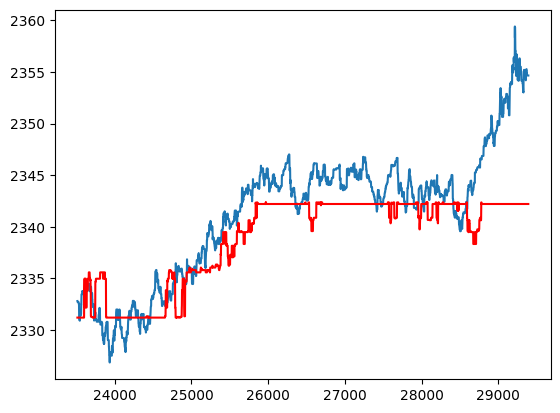

In [335]:
plt.figure()
plt.plot(df_pred['nxt_3m_close'])
plt.plot(df_pred['y_pred'],color='red')

In [338]:
with open('rf_pipe.pkl','wb') as f:
    pickle.dump(best_model,f)

In [340]:
# load
with open('rf_pipe.pkl', 'rb') as f:
    model = pickle.load(f)